
# Chest X-ray Multi-Label Disease Classification With TransCheX 

 training workflow of TransCheX model [1] for chest X-ray multi-label disease classification using Open-I dataset. The TransCheX is multi-modal transformer-based model consisting of vision, language and mixed modality encoder that is designed for chest X-ray image classification.

The Open-I dataset provides a collection of 3,996 radiology reports with 8,121 associated images in PA, AP and lateral views. In this tutorial, we utilize the images from fronal view with their corresponding reports for training and evaluation of the TransChex model.The 14 finding categories in this work include Atelectasis, Cardiomegaly, Consolidation, Edema, Enlarged-Cardiomediastinum, Fracture, Lung-Lesion, Lung-Opacity, No-Finding, Pleural-Effusion, Pleural-Other, Pneumonia, Pneumothorax and Support-Devices. More information can be found in the following link:      
https://openi.nlm.nih.gov/faq

License: Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)

An example of images and corresponding reports in Open-I dataset is presented as follows [2]:
![image](../../figures/openi_sample.png)


In [1]:
!ls


'=24.4'					    media
 NGC-DL-CONTAINER-LICENSE		    mnt
 bin					    monai
 boot					    opt
 cuda-keyring_1.0-1_all.deb		    proc
 dev					    root
 entrypoint.sh				    run
 etc					    run_jupyter.sh
 home					    sbin
 install_packages.sh			    srv
 lib					    sys
 lib32					    tmp
 lib64					    usr
 libnvinfer8_8.6.1.6-1+cuda12.0_amd64.deb   var
 libx32


In [2]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
from os import listdir
from os.path import isfile, join
import numpy as np
from xml.dom import minidom
from PIL import Image
import pandas as pd
import xml.etree.ElementTree as ET


def create_report(img_names_list_, report_list_, gt_list_, save_add):
    pd.DataFrame(
        {
            "id": img_names_list_,
            "report": report_list_,
            "Atelectasis": gt_list_[:, 0],
            "Cardiomegaly": gt_list_[:, 1],
            "Consolidation": gt_list_[:, 2],
            "Edema": gt_list_[:, 3],
            "Enlarged-Cardiomediastinum": gt_list_[:, 4],
            "Fracture": gt_list_[:, 5],
            "Lung-Lesion": gt_list_[:, 6],
            "Lung-Opacity": gt_list_[:, 7],
            "No-Finding": gt_list_[:, 8],
            "Pleural-Effusion": gt_list_[:, 9],
            "Pleural_Other": gt_list_[:, 10],
            "Pneumonia": gt_list_[:, 11],
            "Pneumothorax": gt_list_[:, 12],
            "Support-Devices": gt_list_[:, 13],
        }
    ).to_csv(save_add, index=False)


report_file_add = "monai/monai_data/dataset_orig/NLMCXR_reports/ecgen-radiology"
img_file_add = "monai/monai_data/dataset_orig/NLMCXR_png"
npy_add = "monai/monai_data/TransChex_openi/"

img_save_add = "monai/monai_data/dataset_proc/images"
report_train_save_add = "monai/monai_data/dataset_proc/train.csv"
report_val_save_add = "monai/monai_data/dataset_proc/validation.csv"
report_test_save_add = "monai/monai_data/dataset_proc/test.csv"

if not os.path.isdir(img_save_add):
    os.makedirs(img_save_add)
report_files = [f for f in listdir(report_file_add) if isfile(join(report_file_add, f))]

train_data = np.load(npy_add + "train.npy", allow_pickle=True).item()
train_data_id = train_data["id_GT"]
train_data_gt = train_data["label_GT"]

val_data = np.load(npy_add + "validation.npy", allow_pickle=True).item()
val_data_id = val_data["id_GT"]
val_data_gt = val_data["label_GT"]

test_data = np.load(npy_add + "test.npy", allow_pickle=True).item()
test_data_id = test_data["id_GT"]
test_data_gt = test_data["label_GT"]

all_cases = np.union1d(np.union1d(train_data_id, val_data_id), test_data_id)

img_names_list_train = []
img_names_list_val = []
img_names_list_test = []

report_list_train = []
report_list_val = []
report_list_test = []

gt_list_train = []
gt_list_val = []
gt_list_test = []

for file in report_files:
    print("Processing {}".format(file))
    add_xml = os.path.join(report_file_add, file)
    docs = minidom.parse(add_xml)
    tree = ET.parse(add_xml)
    for node in tree.iter("AbstractText"):
        i = 0
        for elem in node.iter():
            if elem.attrib["Label"] == "FINDINGS":
                if elem.text == None:
                    report = "FINDINGS : "
                else:
                    report = "FINDINGS : " + elem.text
            elif elem.attrib["Label"] == "IMPRESSION":
                if elem.text == None:
                    report = report + " IMPRESSION : "
                else:
                    report = report + " IMPRESSION : " + elem.text
    images = docs.getElementsByTagName("parentImage")
    for i in images:
        img_name = i.getAttribute("id") + ".png"
        if img_name in all_cases:
            Image.open(os.path.join(img_file_add, img_name)).resize((512, 512)).save(
                os.path.join(img_save_add, img_name)
            )
            if img_name in train_data_id:
                img_names_list_train.append(img_name)
                report_list_train.append(report)
                gt_list_train.append(train_data_gt[np.where(train_data_id == img_name)[0][0]])
            elif img_name in val_data_id:
                img_names_list_val.append(img_name)
                report_list_val.append(report)
                gt_list_val.append(val_data_gt[np.where(val_data_id == img_name)[0][0]])
            elif img_name in test_data_id:
                img_names_list_test.append(img_name)
                report_list_test.append(report)
                gt_list_test.append(test_data_gt[np.where(test_data_id == img_name)[0][0]])

datasets = [
    {
        "save_add": report_train_save_add,
        "img_name": np.array(img_names_list_train),
        "report": np.array(report_list_train),
        "gt": np.array(gt_list_train),
    },
    {
        "save_add": report_val_save_add,
        "img_name": np.array(img_names_list_val),
        "report": np.array(report_list_val),
        "gt": np.array(gt_list_val),
    },
    {
        "save_add": report_test_save_add,
        "img_name": np.array(img_names_list_test),
        "report": np.array(report_list_test),
        "gt": np.array(gt_list_test),
    },
]
for dataset in datasets:
    create_report(dataset["img_name"], dataset["report"], dataset["gt"], dataset["save_add"])

print("Processed Dataset Files Are Saved !")


Processing 1.xml
Processing 10.xml
Processing 100.xml
Processing 1000.xml
Processing 1001.xml
Processing 1002.xml
Processing 1003.xml
Processing 1004.xml
Processing 1005.xml
Processing 1006.xml
Processing 1007.xml
Processing 1008.xml
Processing 1009.xml
Processing 101.xml
Processing 1010.xml
Processing 1011.xml
Processing 1012.xml
Processing 1013.xml
Processing 1014.xml
Processing 1015.xml
Processing 1016.xml
Processing 1017.xml
Processing 1018.xml
Processing 1019.xml
Processing 102.xml
Processing 1020.xml
Processing 1021.xml
Processing 1022.xml
Processing 1023.xml
Processing 1024.xml
Processing 1025.xml
Processing 1026.xml
Processing 1027.xml
Processing 1028.xml
Processing 1029.xml
Processing 103.xml
Processing 1030.xml
Processing 1031.xml
Processing 1032.xml
Processing 1033.xml
Processing 1034.xml
Processing 1035.xml
Processing 1036.xml
Processing 1037.xml
Processing 1038.xml
Processing 1039.xml
Processing 104.xml
Processing 1040.xml
Processing 1041.xml
Processing 1042.xml
Processing

## Setup environment

In [3]:
!pip install -q "monai[transformers, pandas]"
!pip install -q scikit-learn==1.0.2
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
bigframes 0.22.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
woodwork 0.31.0 requires scikit-learn>=1.1.0, but you have scikit-learn 1.0.2 which is incompatible.


In [4]:
 !pip uninstall numpy -y
 !pip install numpy==1.22.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 3.6 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
ucxx 0.39.1 requires libucx>=1.15.0, which is not installed.
albucore 0.0.17 requires numpy>=1.24, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.17 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cl

In [5]:
import numpy as np
import scipy
import torch
import monai

print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)
print("PyTorch version:", torch.__version__)
print("MONAI version:", monai.__version__)

NumPy version: 1.26.4
SciPy version: 1.14.1
PyTorch version: 2.4.0
MONAI version: 1.4.0


## Setup imports

In [6]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
#from sklearn.metrics import roc_auc_score
from monai.optimizers.lr_scheduler import WarmupCosineSchedule
from monai.networks.nets import Transchex
from monai.config import print_config
from monai.utils import set_determinism
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

torch.backends.cudnn.benchmark = True
print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.0
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.40.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://do

## Download and pre-process the dataset

Download the Open-I dataset from the following link, for both the chest X-ray images and corresponding reports, and pre-process the dataset using the provided script:

https://openi.nlm.nih.gov/faq

Please refer to the pre-processing guide for more details. 

In [7]:
datadir = "monai/monai_data"
if not os.path.exists(datadir):
    os.makedirs(datadir)

## Set deterministic training for reproducibility


In [8]:
set_determinism(seed=0)

## Setup dataloaders and transforms for training/validation/testomg

In [9]:
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, parent_dir, max_seq_length=512):
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.data = dataframe
        self.report_summary = self.data.report
        self.img_name = self.data.id
        self.targets = self.data.list

        self.preprocess = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )
        self.parent_dir = parent_dir

    def __len__(self):
        return len(self.report_summary)

    def encode_features(self, sent, max_seq_length, tokenizer):
        tokens = tokenizer.tokenize(sent.strip())
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[: (max_seq_length - 2)]
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        segment_ids = [0] * len(input_ids)
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            segment_ids.append(0)
        assert len(input_ids) == max_seq_length
        assert len(segment_ids) == max_seq_length
        return input_ids, segment_ids

    def __getitem__(self, index):
        name = self.img_name[index].split(".")[0]
        img_address = os.path.join(self.parent_dir, self.img_name[index])
        image = Image.open(img_address)
        images = self.preprocess(image)
        report = str(self.report_summary[index])
        report = " ".join(report.split())
        input_ids, segment_ids = self.encode_features(report, self.max_seq_length, self.tokenizer)
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        segment_ids = torch.tensor(segment_ids, dtype=torch.long)
        targets = torch.tensor(self.targets[index], dtype=torch.float)
        return {
            "ids": input_ids,
            "segment_ids": segment_ids,
            "name": name,
            "targets": targets,
            "images": images,
        }

 ## Setup the model directory, tokenizer and dataloaders


In [10]:
def load_txt_gt(add):
    txt_gt = pd.read_csv(add)
    txt_gt["list"] = txt_gt[txt_gt.columns[2:]].values.tolist()
    txt_gt = txt_gt[["id", "report", "list"]].copy()
    return txt_gt


logdir = "./logdir"
if not os.path.exists(logdir):
    os.makedirs(logdir)

parent_dir = "monai/monai_data/dataset_proc/images/"
train_txt_gt = load_txt_gt("monai/monai_data/dataset_proc/train.csv")
val_txt_gt = load_txt_gt("monai/monai_data/dataset_proc/validation.csv")
test_txt_gt = load_txt_gt("monai/monai_data/dataset_proc/test.csv")
batch_size = 32

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=False)
training_set = MultiModalDataset(train_txt_gt, tokenizer, parent_dir)
train_params = {
    "batch_size": batch_size,
    "shuffle": True,

    "pin_memory": True,
}
training_loader = DataLoader(training_set, **train_params)
valid_set = MultiModalDataset(val_txt_gt, tokenizer, parent_dir)
test_set = MultiModalDataset(test_txt_gt, tokenizer, parent_dir)
valid_params = {"batch_size": 1, "shuffle": False, "pin_memory": True}
val_loader = DataLoader(valid_set, **valid_params)
test_loader = DataLoader(test_set, **valid_params)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Create Model, Loss, Optimizer


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_epochs = 15
eval_num = 1
lr = 1e-4
weight_decay = 1e-5

model = Transchex(
    in_channels=3,
    img_size=(256, 256),
    num_classes=14,
    patch_size=(32, 32),
    num_language_layers=2,
    num_vision_layers=2,
    num_mixed_layers=2,
).to(device)

loss_bce = torch.nn.BCELoss().cuda()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = WarmupCosineSchedule(optimizer, warmup_steps=5, t_total=total_epochs)
scheduler.step()  # To avoid lr=0 for Epoch 0.

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/monai/networks/nets/transchex.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location

### Execute a typical PyTorch training process

In [12]:
!pip install --upgrade scikit-learn


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 806.5 kB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 3.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which 

In [13]:
import numpy as np
import torch

def save_ckp(state, checkpoint_dir):
    torch.save(state, checkpoint_dir)

def compute_aucs(gt, pred, num_classes=14):
    """
    Compute the AUCs manually using the trapezoidal rule.
    """
    with torch.no_grad():
        aurocs = []
        for i in range(num_classes):
            gt_class = gt[:, i]
            pred_class = pred[:, i]
            sorted_indices = np.argsort(pred_class)[::-1]
            gt_sorted = gt_class[sorted_indices]
            pred_sorted = pred_class[sorted_indices]
            
            tpr = np.cumsum(gt_sorted) / np.sum(gt_sorted)  # True Positive Rate
            fpr = np.cumsum(1 - gt_sorted) / np.sum(1 - gt_sorted)  # False Positive Rate
            auc = np.trapz(tpr, fpr)  # Trapezoidal integration
            aurocs.append(auc)
    return aurocs

def train(epoch):
    model.train()
    for i, data in enumerate(training_loader, 0):
        input_ids = data["ids"].cuda()
        segment_ids = data["segment_ids"].cuda()
        img = data["images"].cuda()
        targets = data["targets"].cuda()
        logits_lang = model(input_ids=input_ids, vision_feats=img, token_type_ids=segment_ids)
        loss = loss_bce(torch.sigmoid(logits_lang), targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Iteration: {i}, Loss_Tot: {loss}")

def validation(testing_loader):
    model.eval()
    targets_in = np.zeros((len(testing_loader), 14))
    preds_cls = np.zeros((len(testing_loader), 14))
    val_loss = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            input_ids = data["ids"].cuda()
            segment_ids = data["segment_ids"].cuda()
            img = data["images"].cuda()
            targets = data["targets"].cuda()
            logits_lang = model(input_ids=input_ids, vision_feats=img, token_type_ids=segment_ids)
            prob = torch.sigmoid(logits_lang)
            loss = loss_bce(prob, targets).item()
            targets_in[_, :] = targets.detach().cpu().numpy()
            preds_cls[_, :] = prob.detach().cpu().numpy()
            val_loss.append(loss)
        auc = compute_aucs(targets_in, preds_cls, 14)
        mean_auc = np.mean(auc)
        mean_loss = np.mean(val_loss)
        print("Evaluation Statistics: Mean AUC : {}, Mean Loss : {}".format(mean_auc, mean_loss))
    return mean_auc, mean_loss, auc

auc_val_best = 0.0
epoch_loss_values = []
metric_values = []
for epoch in range(total_epochs):
    train(epoch)
    auc_val, loss_val, _ = validation(val_loader)
    epoch_loss_values.append(loss_val)
    metric_values.append(auc_val)
    if auc_val > auc_val_best:
        checkpoint = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_ckp(checkpoint, logdir + "/transchex.pt")
        auc_val_best = auc_val
        print("Model Was Saved ! Current Best Validation AUC: {}    Current AUC: {}".format(auc_val_best, auc_val))
    else:
        print("Model Was NOT Saved ! Current Best Validation AUC: {}    Current AUC: {}".format(auc_val_best, auc_val))
    scheduler.step()


Epoch: 0, Iteration: 0, Loss_Tot: 0.6642206907272339
Epoch: 0, Iteration: 1, Loss_Tot: 0.5934087634086609
Epoch: 0, Iteration: 2, Loss_Tot: 0.532962441444397
Epoch: 0, Iteration: 3, Loss_Tot: 0.45797523856163025
Epoch: 0, Iteration: 4, Loss_Tot: 0.42895856499671936
Epoch: 0, Iteration: 5, Loss_Tot: 0.4022462069988251
Epoch: 0, Iteration: 6, Loss_Tot: 0.38426634669303894
Epoch: 0, Iteration: 7, Loss_Tot: 0.3461938202381134
Epoch: 0, Iteration: 8, Loss_Tot: 0.3316825032234192
Epoch: 0, Iteration: 9, Loss_Tot: 0.32239389419555664
Epoch: 0, Iteration: 10, Loss_Tot: 0.290453165769577
Epoch: 0, Iteration: 11, Loss_Tot: 0.2785601317882538
Epoch: 0, Iteration: 12, Loss_Tot: 0.287222683429718
Epoch: 0, Iteration: 13, Loss_Tot: 0.24722763895988464
Epoch: 0, Iteration: 14, Loss_Tot: 0.2795557379722595
Epoch: 0, Iteration: 15, Loss_Tot: 0.21985454857349396
Epoch: 0, Iteration: 16, Loss_Tot: 0.24923713505268097
Epoch: 0, Iteration: 17, Loss_Tot: 0.27105972170829773
Epoch: 0, Iteration: 18, Loss_Tot

In [14]:
print(f"Training Finished ! Best Validation AUC: {auc_val_best:.4f} ")

Training Finished ! Best Validation AUC: 0.9614 


### Plot the loss and metric

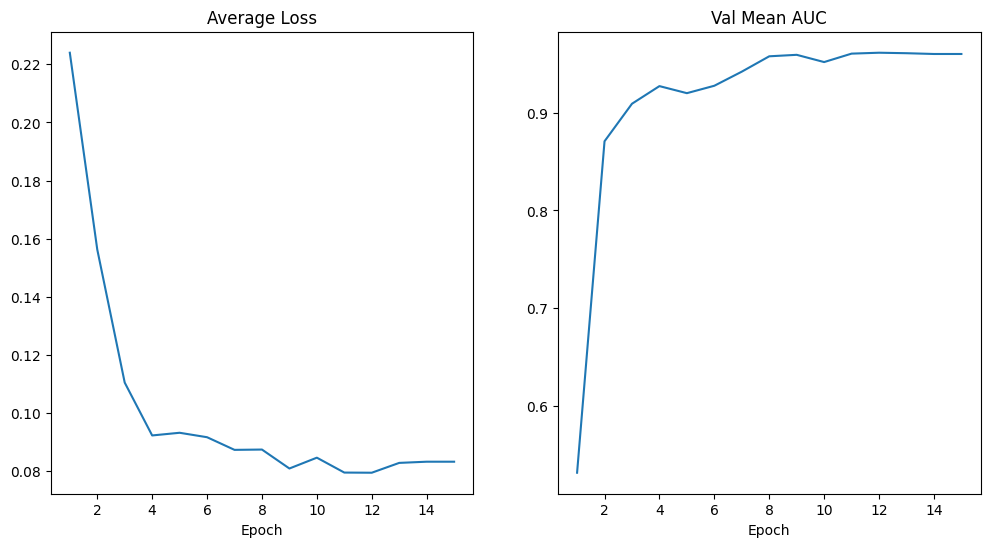

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean AUC")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

In [16]:
model.load_state_dict(torch.load(os.path.join(logdir, "transchex.pt"))["state_dict"])
model.eval()
with torch.no_grad():
    auc_val, loss_val, auc = validation(test_loader)

print(
    "\nMean test AUC for each class in 14 disease categories\
    :\n\nAtelectasis: {}\nCardiomegaly: {}\nConsolidation: {}\nEdema: \
    {}\nEnlarged-Cardiomediastinum: {}\nFracture: {}\nLung-Lesion: {}\nLung-Opacity: \
    {}\nNo-Finding: {}\nPleural-Effusion: {}\nPleural_Other: {}\nPneumonia: \
    {}\nPneumothorax: {}\nSupport-Devices: {}".format(
        auc[0],
        auc[1],
        auc[2],
        auc[3],
        auc[4],
        auc[5],
        auc[6],
        auc[7],
        auc[8],
        auc[9],
        auc[10],
        auc[11],
        auc[12],
        auc[13],
    )
)

/tmp/ipykernel_294/1302775616.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(logdir, "transchex.pt"))["state_dict"])


Evaluation Statistics: Mean AUC : 0.9665802283764008, Mean Loss : 0.07742358375567973

Mean test AUC for each class in 14 disease categories    :

Atelectasis: 0.9921104536489153
Cardiomegaly: 0.972849782005549
Consolidation: 0.9519317160826595
Edema:     0.9866310160427808
Enlarged-Cardiomediastinum: 0.974827521909379
Fracture: 0.9648648648648649
Lung-Lesion: 0.9332425068119892
Lung-Opacity:     0.9802851076736427
No-Finding: 0.9571978780611874
Pleural-Effusion: 0.9102941176470587
Pleural_Other: 0.9946236559139785
Pneumonia:     0.966131907308378
Pneumothorax: 0.9973404255319149
Support-Devices: 0.9497922437673131


In [19]:
# Specify the file path to save the weights
save_path = "monai/model_weights.pth"

# Save the model's state_dict
torch.save(model.state_dict(), save_path)

print(f"Model weights saved to {save_path}")


Model weights saved to monai/model_weights.pth


In [27]:
import os

# Ensure the directory exists
save_dir = "monai/model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Specify the file path to save the weights
save_path = os.path.join(save_dir, "model.pth")

# Save the model's state_dict
torch.save(model.state_dict(), save_path)

print(f"Model weights saved to {save_path}")

Model weights saved to monai/model/model.pth
